<a href="https://colab.research.google.com/github/DingLi23/s2search/blob/pipelining/pipelining/pdp-exp1/pdp-exp1_cslg-rand-100_plotting.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Experiment Description

Produce PDP for a randomly picked data from cslg.

> This notebook is for experiment \<pdp-exp1\> and data sample \<cslg-rand-100\>.

### Initialization

In [16]:
%load_ext autoreload
%autoreload 2
import numpy as np, sys, os
in_colab = 'google.colab' in sys.modules
# fetching code and data(if you are using colab
if in_colab:
    !rm -rf s2search
    !git clone --branch pipelining https://github.com/youyinnn/s2search.git
    sys.path.insert(1, './s2search')
    %cd s2search/pipelining/pdp-exp1/

pic_dir = os.path.join('.', 'plot')
if not os.path.exists(pic_dir):
    os.mkdir(pic_dir)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Loading data

In [17]:
sys.path.insert(1, '../../')
import numpy as np, sys, os, pandas as pd
from s2search_score_pdp import pdp_based_importance, apply_order

sample_name = 'cslg-rand-100'

f_list = ['title', 'abstract', 'venue', 'authors', 'year', 'n_citations']

pdp_xy = {}
pdp_metric = pd.DataFrame(columns=['feature_name', 'pdp_range', 'pdp_importance'])

for f in f_list:
    file = os.path.join('.', 'scores', f'{sample_name}_pdp_{f}.npz')
    if os.path.exists(file):
        data = np.load(file)
        sorted_pdp_data = apply_order(data)
        feature_pdp_data = [np.mean(pdps) for pdps in sorted_pdp_data]
        
        pdp_xy[f] = {
            'y': feature_pdp_data,
            'numerical': True
        }
        if f == 'year' or f == 'n_citations':
            pdp_xy[f]['x'] = np.sort(data['arr_1'])
        else:
            pdp_xy[f]['y'] = feature_pdp_data
            pdp_xy[f]['x'] = list(range(len(feature_pdp_data)))
            pdp_xy[f]['numerical'] = False
            
        pdp_metric.loc[len(pdp_metric.index)] = [f, np.max(feature_pdp_data) - np.min(feature_pdp_data), pdp_based_importance(feature_pdp_data, f)]
            
        pdp_xy[f]['weird'] = feature_pdp_data[len(feature_pdp_data) - 1] > 30
        

print(pdp_metric.sort_values(by=['pdp_importance'], ascending=False))


  feature_name  pdp_range  pdp_importance
1     abstract  17.447716        5.683929
0        title  16.866788        3.660768
2        venue  14.048029        1.663986
4         year   2.022948        0.454161
5  n_citations   0.818973        0.190772
3      authors   0.000000        0.000000


### PDP

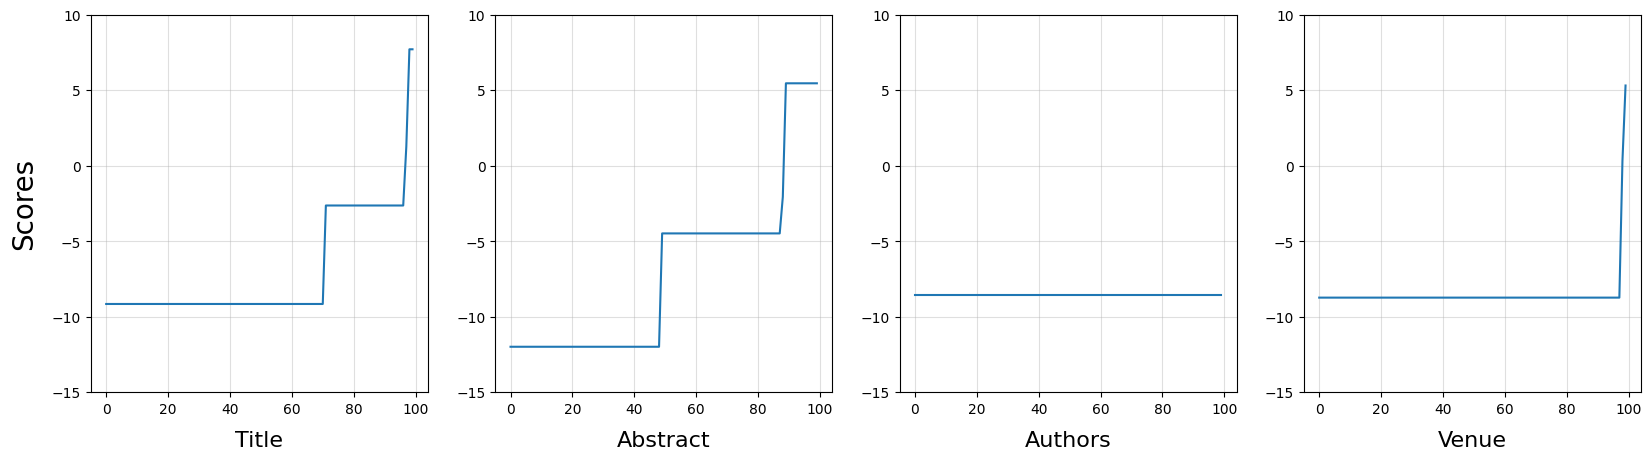

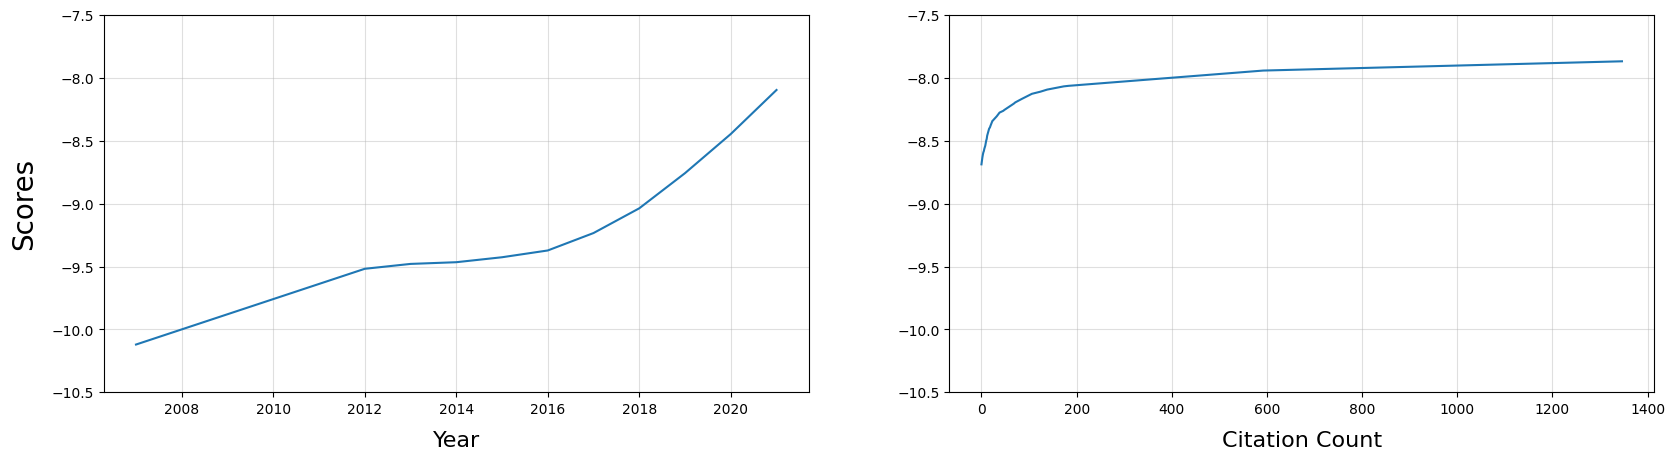

In [18]:
import matplotlib.pyplot as plt

categorical_plot_conf = [
    {
        'xlabel': 'Title',
        'ylabel': 'Scores',
        'pdp_xy': pdp_xy['title']
    },
    {
        'xlabel': 'Abstract',
        'pdp_xy': pdp_xy['abstract']
    },    
    {
        'xlabel': 'Authors',
        'pdp_xy': pdp_xy['authors']
    },
    {
        'xlabel': 'Venue',
        'pdp_xy': pdp_xy['venue'],
        # 'zoom': {
        #     'inset_axes': [0.15, 0.45, 0.47, 0.47],
        #     'x_limit': [950, 1010],
        #     'y_limit': [-9, 7],
        #     'connects': [True, True, False, False]
        # }
    },
]

numerical_plot_conf = [
    {
        'xlabel': 'Year',
        'ylabel': 'Scores',
        'pdp_xy': pdp_xy['year']
    },
    {
        'xlabel': 'Citation Count',
        'pdp_xy': pdp_xy['n_citations'],
        # 'zoom': {
        #     'inset_axes': [0.5, 0.2, 0.47, 0.47],
        #     'x_limit': [-100, 1000],
        #     'y_limit': [-7.3, -6.2],
        #     'connects': [False, False, True, True]
        # }
    }
]

def pdp_plot(confs, title):
    fig, axes = plt.subplots(nrows=1, ncols=len(confs), figsize=(20, 5), dpi=100)
    subplot_idx = 0
    # plt.suptitle(title, fontsize=20, fontweight='bold')
    # plt.autoscale(False)
    for conf in confs:
        axess = axes if len(confs) == 1 else axes[subplot_idx]

        axess.plot(conf['pdp_xy']['x'], conf['pdp_xy']['y'])
        axess.grid(alpha = 0.4)

        if ('ylabel' in conf):
            axess.set_ylabel(conf.get('ylabel'), fontsize=20, labelpad=10)
        
        axess.set_xlabel(conf['xlabel'], fontsize=16, labelpad=10)
        
        if not (conf['pdp_xy']['weird']):
            if (conf['pdp_xy']['numerical']):
                axess.set_ylim([-10.5, -7.5])
                pass
            else:
                axess.set_ylim([-15, 10])
                pass
                
        if 'zoom' in conf:
            axins = axess.inset_axes(conf['zoom']['inset_axes']) 
            axins.plot(conf['pdp_xy']['x'], conf['pdp_xy']['y'])
            axins.set_xlim(conf['zoom']['x_limit'])
            axins.set_ylim(conf['zoom']['y_limit'])
            axins.grid(alpha=0.3)
            rectpatch, connects = axess.indicate_inset_zoom(axins)
            connects[0].set_visible(conf['zoom']['connects'][0])
            connects[1].set_visible(conf['zoom']['connects'][1])
            connects[2].set_visible(conf['zoom']['connects'][2])
            connects[3].set_visible(conf['zoom']['connects'][3])
            
        subplot_idx += 1

pdp_plot(categorical_plot_conf, "PDPs for four categorical features")
plt.savefig(os.path.join('.', 'plot', f'{sample_name}-categorical.png'), facecolor='white', transparent=False, bbox_inches='tight')

# second fig
pdp_plot(numerical_plot_conf, "PDPs for two numerical features")
plt.savefig(os.path.join('.', 'plot', f'{sample_name}-numerical.png'), facecolor='white', transparent=False, bbox_inches='tight')
